## KNN Model

### Connect to data sources and import libraries for modeling

In [1]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! pip install dmba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import sqlite3
import csv

import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from dmba import classificationSummary
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from imblearn.over_sampling import SMOTE

%matplotlib inline

# Turn off warnings for ease of viewing
import warnings
warnings.filterwarnings("ignore")

# Set option to see all columns in output
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)

no display found. Using non-interactive Agg backend


### Connect to SQL database and bring in the transformed_data table

In [4]:
# Connect to the database
conn = sqlite3.connect('/content/drive/My Drive/MS-ADS Capstone Project/data/hr_case_study.db')

##### Query general_data table ##### 
# Create cursor object and query table
cursor = conn.cursor()
cursor.execute('SELECT * FROM transformed_data AS d')

# Identify the column names for dataframe
col_names = [desc[0] for desc in cursor.description]

# Fetch all rows from the query and store in dataframe
rows = cursor.fetchall()
transformed_sql= pd.DataFrame(rows, columns = col_names)

# Close the cursor and connection objects
cursor.close()
conn.close()

In [5]:
transformed_sql.head()

,index,Unnamed: 0,Education,EmployeeID,JobLevel,NumCompaniesWorked,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,time_id,mean_time,median_time,max_time,num_times_over_9hours,num_times_over_11hours,%_under_8,%_over_9,%_over_11,clipped_TrainingTimesLastYear,clipped_NumCompaniesWorked,log_Age,log_StockOptionLevel,log_YearsSinceLastPromotion,log_TotalWorkingYears,log_YearsAtCompany,log_MonthlyIncome,log_PercentSalaryHike,log_DistanceFromHome,log_clipped_YearsWithCurrentManager,log_clipped_num_times_less_8hours,log_total_days,log_num_times_over_9hours,log_num_times_over_11hours,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,Attrition_Yes,Gender_Male,log_AgeBeganWorking,log_WorkingDaysPerYear
0,0,0,0.25,1,1,1.0,0.666667,0.0,0.666667,1.000000,0.333333,1,0 days 07:22:26.896551724,0 days 07:23:00,0 days 07:57:00,0,0,1.0,0.0,0.0,1.00,0.125,0.863147,0.000000,0.00,0.186652,0.186652,0.858755,0.000000,0.462607,0.000000,0.992462,0.847162,0.0,0.0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.858668,0.926953
1,1,1,0.00,2,1,0.0,0.333333,1.0,0.666667,0.333333,1.000000,2,0 days 07:43:03.813559322,0 days 07:43:00,0 days 08:34:00,0,0,1.0,0.0,0.0,0.50,0.000,0.446915,0.301030,0.25,0.482489,0.482489,0.476600,0.896477,0.629511,0.671188,0.959652,0.791635,0.0,0.0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0.305588,0.626674
2,2,2,0.75,3,4,1.0,0.666667,0.0,0.333333,0.333333,0.000000,3,0 days 07:00:48.595041322,0 days 06:59:00,0 days 07:59:00,0,0,1.0,0.0,0.0,0.25,0.125,0.473296,0.602060,0.00,0.482489,0.482489,0.988573,0.372072,0.811368,0.578130,1.000000,0.859920,0.0,0.0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0.337215,0.663684
3,3,3,1.00,4,3,3.0,0.333333,0.0,1.000000,1.000000,0.666667,4,0 days 07:11:36.510638298,0 days 07:11:00,0 days 07:53:00,0,0,1.0,0.0,0.0,1.00,0.375,0.616513,0.602060,0.75,0.591674,0.591674,0.706394,0.000000,0.149726,0.747222,0.994756,0.851046,0.0,0.0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0.425729,0.581211
4,4,4,0.00,5,1,4.0,0.666667,0.0,1.000000,0.000000,0.666667,5,0 days 08:00:22.530612245,0 days 07:58:00,0 days 08:50:00,0,0,1.0,0.0,0.0,0.25,0.500,0.473296,0.477121,0.00,0.524000,0.524000,0.281920,0.103523,0.629511,0.671188,0.884149,0.663853,0.0,0.0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0.305588,0.528216


In [6]:
# Columns to keep and create the final base analytics table
cols_to_keep = ['Attrition_Yes','Education','JobLevel','clipped_NumCompaniesWorked','JobInvolvement','PerformanceRating','EnvironmentSatisfaction',
                'JobSatisfaction','WorkLifeBalance','%_over_11','clipped_TrainingTimesLastYear','log_Age','log_StockOptionLevel','log_YearsSinceLastPromotion',
                'log_TotalWorkingYears','log_YearsAtCompany','log_MonthlyIncome','log_PercentSalaryHike','log_DistanceFromHome','log_clipped_YearsWithCurrentManager',
                'BusinessTravel_Travel_Frequently','Department_Research & Development','Department_Sales','JobRole_Manager','JobRole_Sales Representative',
                'EducationField_Technical Degree']

model_df = transformed_sql[cols_to_keep]
model_df.head()

,Attrition_Yes,Education,JobLevel,clipped_NumCompaniesWorked,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,%_over_11,clipped_TrainingTimesLastYear,log_Age,log_StockOptionLevel,log_YearsSinceLastPromotion,log_TotalWorkingYears,log_YearsAtCompany,log_MonthlyIncome,log_PercentSalaryHike,log_DistanceFromHome,log_clipped_YearsWithCurrentManager,BusinessTravel_Travel_Frequently,Department_Research & Development,Department_Sales,JobRole_Manager,JobRole_Sales Representative,EducationField_Technical Degree
0,0,0.25,1,0.125,0.666667,0.0,0.666667,1.000000,0.333333,0.0,1.00,0.863147,0.000000,0.00,0.186652,0.186652,0.858755,0.000000,0.462607,0.000000,0,0,1,0,0,0
1,1,0.00,1,0.000,0.333333,1.0,0.666667,0.333333,1.000000,0.0,0.50,0.446915,0.301030,0.25,0.482489,0.482489,0.476600,0.896477,0.629511,0.671188,1,1,0,0,0,0
2,0,0.75,4,0.125,0.666667,0.0,0.333333,0.333333,0.000000,0.0,0.25,0.473296,0.602060,0.00,0.482489,0.482489,0.988573,0.372072,0.811368,0.578130,1,1,0,0,0,0
3,0,1.00,3,0.375,0.333333,0.0,1.000000,1.000000,0.666667,0.0,1.00,0.616513,0.602060,0.75,0.591674,0.591674,0.706394,0.000000,0.149726,0.747222,0,1,0,0,0,0
4,0,0.00,1,0.500,0.666667,0.0,1.000000,0.000000,0.666667,0.0,0.25,0.473296,0.477121,0.00,0.524000,0.524000,0.281920,0.103523,0.629511,0.671188,0,1,0,0,0,0


### Create KNN Model

In [7]:
# Assign the independent and dependent variables
y = model_df['Attrition_Yes']
X = model_df.drop(columns = ['Attrition_Yes'])

# partitioning data into 90% train and 10% test, and then will further split for validation
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1, random_state = 12345)

# using 80 / 20 split for train and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 12345)

# Balancing data
# Using SMOTE so we don't lose data and synthetically create new data points
# may still result in overfitting to some degree

smote = SMOTE(sampling_strategy='minority',random_state=0)
X_train_smt, y_train_smt = smote.fit_resample(X_train, y_train) # X_smt and y_smt will be used in modeling if concerns around balanced data

y_train_smt.value_counts()

0    2945
1    2945
Name: Attrition_Yes, dtype: int64

In [8]:
# Create the test, train split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1234)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3528, 25)
(3528,)
(882, 25)
(882,)


In [9]:
#X_test.head()

#### Euclidian Distnace

In [10]:
#define knn parameters
k_values = range(1,20,2)
metric = "euclidean"
knn_accuracy = []
clfs =[]
classification_report = []

# Create the KNN function
def k_neighbors(X_train, y_train, X_test, 
                y_test, kvalues, metric):
  for i in kvalues:
    clf = KNeighborsClassifier(metric=metric,p=2, n_neighbors=i).fit(X_train, 
                                                                     y_train)
    clf_train_pred = clf.predict(X_train)
    clf_test_pred = clf.predict(X_test)
    clfs.append(clf)
    knn_accuracy.append({'k values': i,
    'Training Accuracy':accuracy_score(clf_train_pred, y_train),
    'Test Accuracy': accuracy_score(clf_test_pred, y_test)})

  return pd.DataFrame(knn_accuracy,clfs)

# Create the KNN dataframe to view outputs for values of K
knn_df = k_neighbors(X_train, y_train, X_test,
                     y_test, k_values, metric)
knn_df

,k values,Training Accuracy,Test Accuracy
"KNeighborsClassifier(metric='euclidean', n_neighbors=1)",1,1.000000,0.982993
"KNeighborsClassifier(metric='euclidean', n_neighbors=3)",3,0.991497,0.912698
KNeighborsClassifier(metric='euclidean'),5,0.935374,0.812925
"KNeighborsClassifier(metric='euclidean', n_neighbors=7)",7,0.883787,0.867347
"KNeighborsClassifier(metric='euclidean', n_neighbors=9)",9,0.883503,0.846939
"KNeighborsClassifier(metric='euclidean', n_neighbors=11)",11,0.864229,0.845805
"KNeighborsClassifier(metric='euclidean', n_neighbors=13)",13,0.860261,0.850340
"KNeighborsClassifier(metric='euclidean', n_neighbors=15)",15,0.855442,0.845805
"KNeighborsClassifier(metric='euclidean', n_neighbors=17)",17,0.850057,0.846939
"KNeighborsClassifier(metric='euclidean', n_neighbors=19)",19,0.845238,0.845805


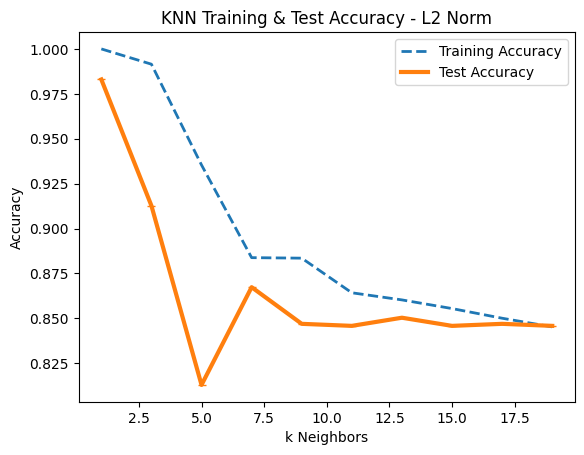

In [11]:
# Plot training and testing accuracy for diffeerent values of K
plt.plot(knn_df['k values'], knn_df['Training Accuracy'], '--',linewidth=2, label='Training Accuracy')
plt.plot(knn_df['k values'], knn_df['Test Accuracy'], '-_',linewidth=3, label='Test Accuracy')

# Repeat the same plot as above but this time for test accutracy
plt.xlabel('k Neighbors')
plt.ylabel('Accuracy')
plt.title('KNN Training & Test Accuracy - L2 Norm')
plt.legend()
plt.show()

In [12]:
#return the results of the most accurate KNN model - Euclidean
knn_euc = KNeighborsClassifier(metric=metric,p=2, n_neighbors=3).fit(X_train, 
                                                                     y_train)
knn_train = knn_euc.fit(X_train, y_train)  
y_pred_knn_euc = knn_train.predict(X_test)

#return the predicted probabilites into a single variable for training and test
knn_test_prob_euc =  knn_euc.predict_proba(X_test)

print('accuracy %2.2f ' % accuracy_score(y_test,y_pred_knn_euc))

accuracy 0.91 


In [13]:
#knn_test_prob_euc

In [14]:
# Create confusion Matrix for KNN Euclidean
cm_mod_test_knn = confusion_matrix(y_test,y_pred_knn_euc)
labels_mod = ['Yes','No']

test_results_knn = pd.DataFrame(cm_mod_test_knn, index = labels_mod, 
                                  columns = labels_mod)
test_results_knn

,Yes,No
Yes,711,43
No,34,94


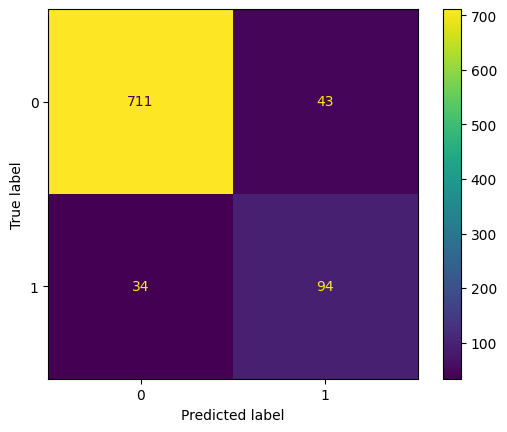

In [15]:
from sklearn import metrics
confusion_matrix_euc = metrics.confusion_matrix(y_test,y_pred_knn_euc)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_euc)
cm_display.plot()
plt.show()

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
# Print the Classification Report
print('\nClassification Report for KNN - Euclidean Classifier:\n')
print(classification_report(y_test, y_pred_knn_euc))
print('\n')


Classification Report for KNN - Euclidean Classifier:

              precision    recall  f1-score   support

           0       0.95      0.94      0.95       754
           1       0.69      0.73      0.71       128

    accuracy                           0.91       882
   macro avg       0.82      0.84      0.83       882
weighted avg       0.92      0.91      0.91       882





### Manhattan Distance

In [17]:
k_values = range(1,20,2)
metric = "manhattan"
knn_accuracy = []
clfs =[]

def k_neighbors(X_train, y_train, X_test, 
                y_test, kvalues, metric):
  for i in kvalues:
    clf = KNeighborsClassifier(metric=metric,p=2, n_neighbors=i).fit(X_train, 
                                                                     y_train)
    clf_train_pred = clf.predict(X_train)
    clf_test_pred = clf.predict(X_test)
    clfs.append(clf)
    knn_accuracy.append({'k values': i,
    'Training Accuracy':accuracy_score(clf_train_pred, y_train),
    'Test Accuracy': accuracy_score(clf_test_pred, y_test)})
  return pd.DataFrame(knn_accuracy,clfs)

knn_df_man = k_neighbors(X_train, y_train, X_test,
                     y_test, k_values, metric)
knn_df_man

,k values,Training Accuracy,Test Accuracy
"KNeighborsClassifier(metric='manhattan', n_neighbors=1)",1,1.000000,0.982993
"KNeighborsClassifier(metric='manhattan', n_neighbors=3)",3,0.992630,0.922902
KNeighborsClassifier(metric='manhattan'),5,0.938776,0.828798
"KNeighborsClassifier(metric='manhattan', n_neighbors=7)",7,0.886621,0.876417
"KNeighborsClassifier(metric='manhattan', n_neighbors=9)",9,0.882653,0.859410
"KNeighborsClassifier(metric='manhattan', n_neighbors=11)",11,0.862812,0.850340
"KNeighborsClassifier(metric='manhattan', n_neighbors=13)",13,0.859410,0.867347
"KNeighborsClassifier(metric='manhattan', n_neighbors=15)",15,0.858844,0.856009
"KNeighborsClassifier(metric='manhattan', n_neighbors=17)",17,0.858844,0.859410
"KNeighborsClassifier(metric='manhattan', n_neighbors=19)",19,0.853741,0.862812


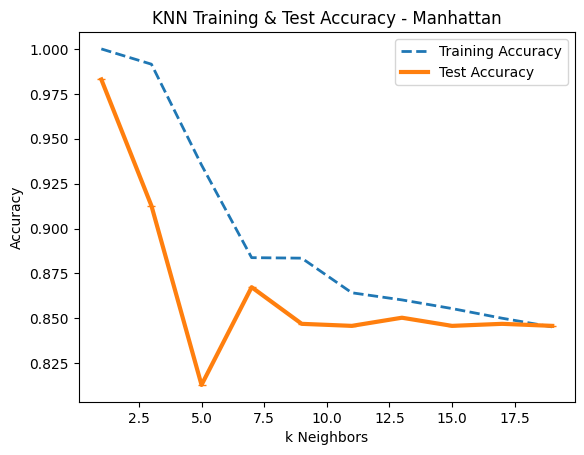

In [18]:
plt.plot(knn_df_man['k values'], knn_df['Training Accuracy'], '--',linewidth=2, label='Training Accuracy')
plt.plot(knn_df_man['k values'], knn_df['Test Accuracy'], '-_',linewidth=3, label='Test Accuracy')

# Repeat the same plot as above but this time for test accuracy
plt.xlabel('k Neighbors')
plt.ylabel('Accuracy')
plt.title('KNN Training & Test Accuracy - Manhattan')
plt.legend()
plt.show()

In [19]:
#return the results of the most accurate KNN model
knn_accuracy = KNeighborsClassifier(metric='manhattan',p=2, n_neighbors=3).fit(X_train, 
                                                                     y_train)
knn_train = knn_accuracy.fit(X_train, y_train)  
y_pred_knn_man = knn_train.predict(X_test)
print('accuracy %2.2f ' % accuracy_score(y_test,y_pred_knn_man))

accuracy 0.92 


In [20]:
cm_mod_test_knn_man = confusion_matrix(y_test,y_pred_knn_man)
labels_mod = ['Yes','No']

test_results_knn_man = pd.DataFrame(cm_mod_test_knn_man, index = labels_mod, 
                                  columns = labels_mod)

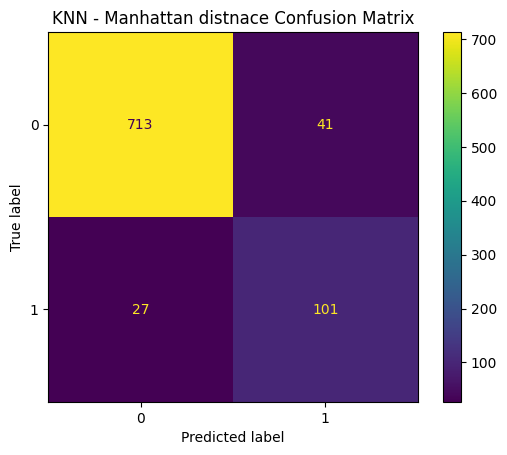

In [21]:
confusion_matrix_man = metrics.confusion_matrix(y_test,y_pred_knn_man)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_man)
cm_display.plot()
plt.title("KNN - Manhattan distnace Confusion Matrix")
plt.show()

In [22]:
from sklearn.metrics import confusion_matrix, classification_report
print('\nClassification Report KNN - Manhattan Classifier:\n')
print(classification_report(y_test, y_pred_knn_man))
print('\n')


Classification Report KNN - Manhattan Classifier:

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       754
           1       0.71      0.79      0.75       128

    accuracy                           0.92       882
   macro avg       0.84      0.87      0.85       882
weighted avg       0.93      0.92      0.92       882





#### Model rebuild with Adjust varirables

In [23]:
## Getting rid of features w/ high multi-collinearity and low importance in both DT and RF
cols_drop = ['log_YearsAtCompany', 'log_TotalWorkingYears', 'JobRole_Sales Representative', 'PerformanceRating', 'JobRole_Manager', 'Department_Research & Development']
model_df_small = model_df.drop(cols_drop, axis = 1)

In [32]:
# Assign the independent and dependent variables
y_s = model_df_small['Attrition_Yes']
X_s = model_df_small.drop(columns = ['Attrition_Yes'])


# partitioning data into 90% train and 10% test, and then will further split for validation
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s, y_s, test_size = .2, random_state = 12345)


# using 80 / 20 split for train and validation set
X_train_s, X_valid_s, y_train_s, y_valid_s = train_test_split(X_train_s, y_train_s, test_size = .2, random_state = 12345)

In [33]:
# Balancing data
# Using SMOTE so we don't lose data and synthetically create new data points
# may still result in overfitting to some degree
smote = SMOTE(sampling_strategy='minority',random_state=0)
X_train_smt_s, y_train_smt_s = smote.fit_resample(X_train_s, y_train_s) # X_smt and y_smt will be used in modeling if concerns around balanced data

y_train_smt_s.value_counts()

0    2347
1    2347
Name: Attrition_Yes, dtype: int64

In [34]:
#define knn parameters
k_values = range(1,20,2)
metric = "euclidean"
knn_accuracy = []
clfs =[]
classification_report = []

# Create the KNN function
def k_neighbors(X_train, y_train, X_test, 
                y_test, kvalues, metric):
  for i in kvalues:
    clf = KNeighborsClassifier(metric=metric,p=2, n_neighbors=i).fit(X_train, 
                                                                     y_train)
    clf_train_pred = clf.predict(X_train)
    clf_test_pred = clf.predict(X_test)
    clfs.append(clf)
    knn_accuracy.append({'k values': i,
    'Training Accuracy':accuracy_score(clf_train_pred, y_train),
    'Test Accuracy': accuracy_score(clf_test_pred, y_test)})

  return pd.DataFrame(knn_accuracy,clfs)

# Create the KNN dataframe to view outputs for values of K
knn_df = k_neighbors(X_train_smt_s, y_train_smt_s, X_test_s,
                     y_test_s, k_values, metric)
knn_df

,k values,Training Accuracy,Test Accuracy
"KNeighborsClassifier(metric='euclidean', n_neighbors=1)",1,1.000000,0.954649
"KNeighborsClassifier(metric='euclidean', n_neighbors=3)",3,0.985939,0.862812
KNeighborsClassifier(metric='euclidean'),5,0.946314,0.791383
"KNeighborsClassifier(metric='euclidean', n_neighbors=7)",7,0.906050,0.777778
"KNeighborsClassifier(metric='euclidean', n_neighbors=9)",9,0.891990,0.761905
"KNeighborsClassifier(metric='euclidean', n_neighbors=11)",11,0.869834,0.721088
"KNeighborsClassifier(metric='euclidean', n_neighbors=13)",13,0.859821,0.709751
"KNeighborsClassifier(metric='euclidean', n_neighbors=15)",15,0.843843,0.690476
"KNeighborsClassifier(metric='euclidean', n_neighbors=17)",17,0.831487,0.658730
"KNeighborsClassifier(metric='euclidean', n_neighbors=19)",19,0.822326,0.638322


In [35]:
k_values = range(1,20,2)
metric = "manhattan"
knn_accuracy = []
clfs =[]

def k_neighbors(X_train, y_train, X_test, 
                y_test, kvalues, metric):
  for i in kvalues:
    clf = KNeighborsClassifier(metric=metric,p=2, n_neighbors=i).fit(X_train, 
                                                                     y_train)
    clf_train_pred = clf.predict(X_train)
    clf_test_pred = clf.predict(X_test)
    clfs.append(clf)
    knn_accuracy.append({'k values': i,
    'Training Accuracy':accuracy_score(clf_train_pred, y_train),
    'Test Accuracy': accuracy_score(clf_test_pred, y_test)})
  return pd.DataFrame(knn_accuracy,clfs)

knn_df_man = k_neighbors(X_train_smt_s, y_train_smt_s, X_test_s,
                     y_test_s, k_values, metric)
knn_df_man

,k values,Training Accuracy,Test Accuracy
"KNeighborsClassifier(metric='manhattan', n_neighbors=1)",1,1.000000,0.955782
"KNeighborsClassifier(metric='manhattan', n_neighbors=3)",3,0.990626,0.886621
KNeighborsClassifier(metric='manhattan'),5,0.958458,0.831066
"KNeighborsClassifier(metric='manhattan', n_neighbors=7)",7,0.927780,0.810658
"KNeighborsClassifier(metric='manhattan', n_neighbors=9)",9,0.910311,0.786848
"KNeighborsClassifier(metric='manhattan', n_neighbors=11)",11,0.892629,0.761905
"KNeighborsClassifier(metric='manhattan', n_neighbors=13)",13,0.887303,0.760771
"KNeighborsClassifier(metric='manhattan', n_neighbors=15)",15,0.877077,0.739229
"KNeighborsClassifier(metric='manhattan', n_neighbors=17)",17,0.856412,0.725624
"KNeighborsClassifier(metric='manhattan', n_neighbors=19)",19,0.848743,0.725624


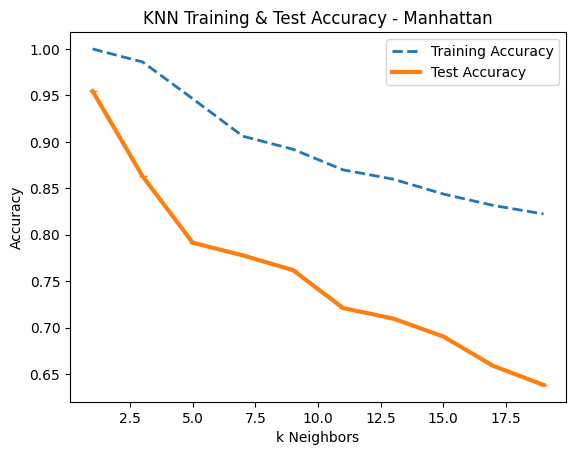

In [36]:
# Create the training and testing plot of different values of K 
plt.plot(knn_df_man['k values'], knn_df['Training Accuracy'], '--',linewidth=2, label='Training Accuracy')
plt.plot(knn_df_man['k values'], knn_df['Test Accuracy'], '-_',linewidth=3, label='Test Accuracy')

# Repeat the same plot as above but this time for test accuracy
plt.xlabel('k Neighbors')
plt.ylabel('Accuracy')
plt.title('KNN Training & Test Accuracy - Manhattan')
plt.legend()
plt.show()

In [37]:
#return the results of the most accurate KNN model
knn_accuracy = KNeighborsClassifier(metric='manhattan',p=2, n_neighbors=3).fit(X_train, 
                                                                     y_train)
knn_train = knn_accuracy.fit(X_train_smt_s, y_train_smt_s)  
y_pred_knn_man_s = knn_train.predict(X_test_s)
print('accuracy %2.2f ' % accuracy_score(y_test_s,y_pred_knn_man_s))

accuracy 0.89 


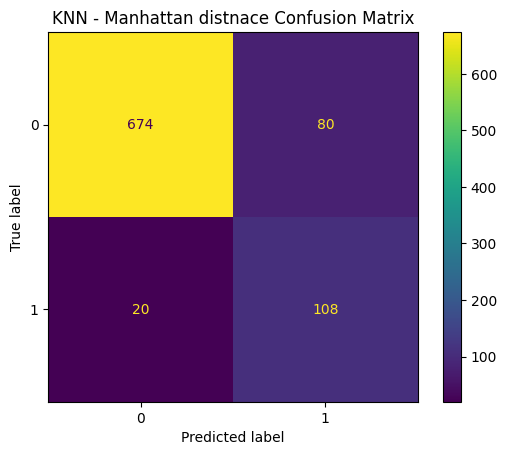

In [38]:
confusion_matrix_man_s = metrics.confusion_matrix(y_test_s,y_pred_knn_man_s)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_man_s)
cm_display.plot()
plt.title("KNN - Manhattan distnace Confusion Matrix")
plt.show()

In [39]:
from sklearn.metrics import confusion_matrix, classification_report
print('\nClassification Report KNN - Manhattan Classifier:\n')
print(classification_report(y_test_s, y_pred_knn_man_s))
print('\n')


Classification Report KNN - Manhattan Classifier:

              precision    recall  f1-score   support

           0       0.97      0.89      0.93       754
           1       0.57      0.84      0.68       128

    accuracy                           0.89       882
   macro avg       0.77      0.87      0.81       882
weighted avg       0.91      0.89      0.90       882



